# Part 5 Modeling Credit Card Default Risk and Customer Profitability

***

## Project Description

The President of the bank asks you to design and implement a predictive model to determine which future applicants should be approved for a credit card and which rejected. 

Your new goal is to develop a binary classification process for “approve” or “reject” designed to maximize total bank profits. (Put another way, you want to maximize average profits per applicant, including in the total number of applicants those that are rejected).

Default is the failure to repay a debt, including interest or principal, on a loan or security. A default can occur when a borrower is unable to make timely payments, misses payments, or avoids or stops making payments.

## Business Task

## Import Libraries

In [1]:
import numpy as np
from numpy import count_nonzero
from numpy import median
from numpy import mean
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

import datetime
from datetime import datetime, timedelta

import scipy.stats
from collections import Counter


import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

%matplotlib inline
#sets the default autosave frequency in seconds
%autosave 60 
sns.set_style('dark')
sns.set(font_scale=1.2)

plt.rc('axes', titlesize=9)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format','{:.2f}'.format)

random.seed(0)
np.random.seed(0)
np.set_printoptions(suppress=True)

Autosaving every 60 seconds


## Exploratory Data Analysis

In [2]:
df = pd.read_csv("train2.csv")

In [3]:
df

,YearsatEmployer,Income,CreditCardDebt,AutomobileDebt,Default
0,9.39,37843.68,-3246.66,-4794.71,0
1,11.97,65765.23,-15597.78,-17632.17,1
2,12.46,61002.29,-11401.92,-7910.24,1
3,1.39,19952.73,-1233.38,-2408.10,0
4,7.49,24970.13,-1135.68,-397.32,0
...,...,...,...,...,...
195,13.25,58643.79,-5164.71,-11395.31,0
196,7.82,17453.12,-983.58,-1431.84,0
197,2.37,27214.16,-1446.02,-2100.69,0
198,16.69,115210.82,-3205.97,-25826.62,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearsatEmployer  200 non-null    float64
 1   Income           200 non-null    float64
 2   CreditCardDebt   200 non-null    float64
 3   AutomobileDebt   200 non-null    float64
 4   Default          200 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [5]:
df.describe()

,YearsatEmployer,Income,CreditCardDebt,AutomobileDebt,Default
count,200.00,200.00,200.00,200.00,200.00
mean,8.61,48439.96,-3202.11,-6378.07,0.25
std,6.79,47982.46,3901.79,7491.20,0.43
min,0.04,11522.10,-32050.38,-55418.57,0.00
25%,3.40,23207.97,-4242.42,-7902.88,0.00
50%,7.50,33884.08,-1822.00,-3922.68,0.00
75%,12.52,58330.22,-810.92,-2101.18,0.25
max,31.65,451319.67,34.16,1747.24,1.00


In [6]:
df.columns

Index(['YearsatEmployer', 'Income', 'CreditCardDebt', 'AutomobileDebt', 'Default'], dtype='object')

In [7]:
debt = df.CreditCardDebt.sum() + df.AutomobileDebt.sum()
debt / 200

-9580.1829

## Data Visualization

### Univariate Data Exploration

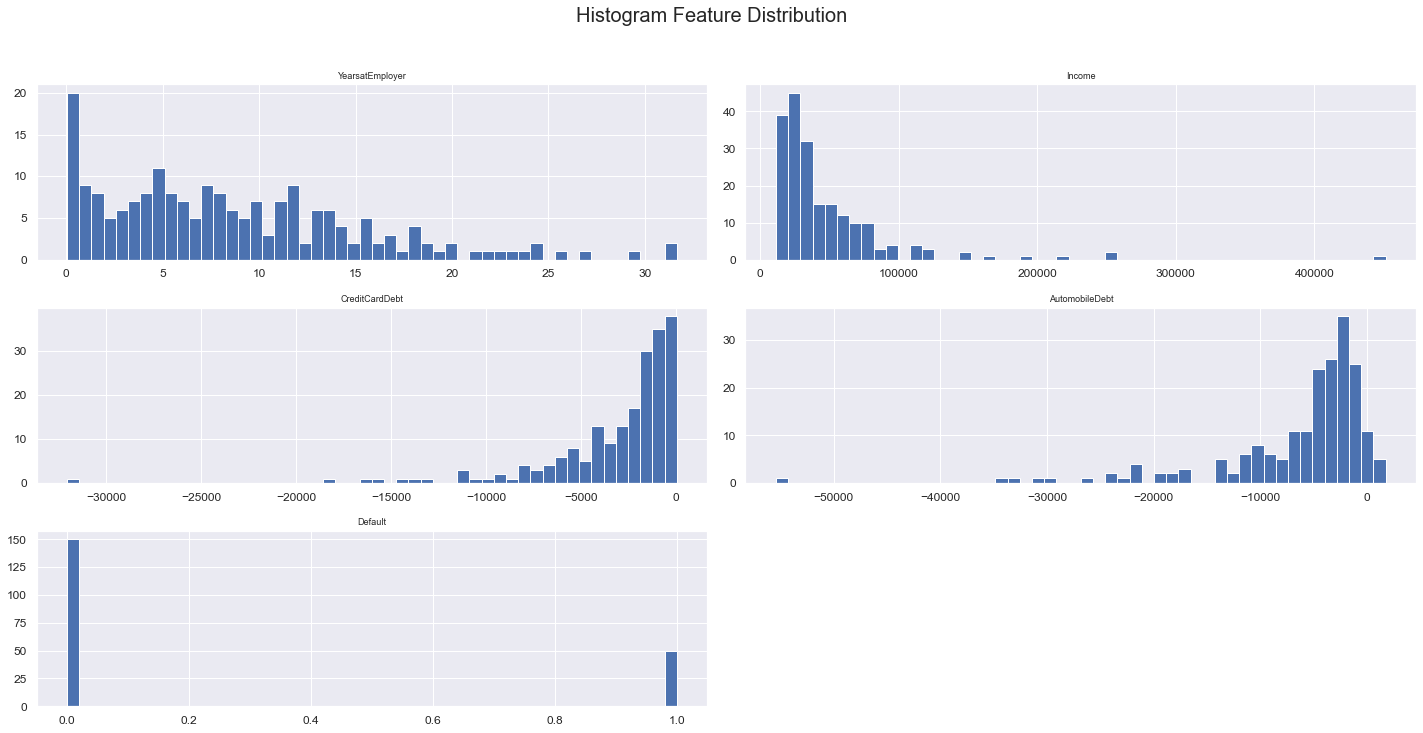

In [8]:
df.hist(bins=50, figsize=(20,10))
plt.suptitle('Histogram Feature Distribution', x=0.5, y=1.02, ha='center', fontsize=20)
plt.tight_layout()
plt.show()

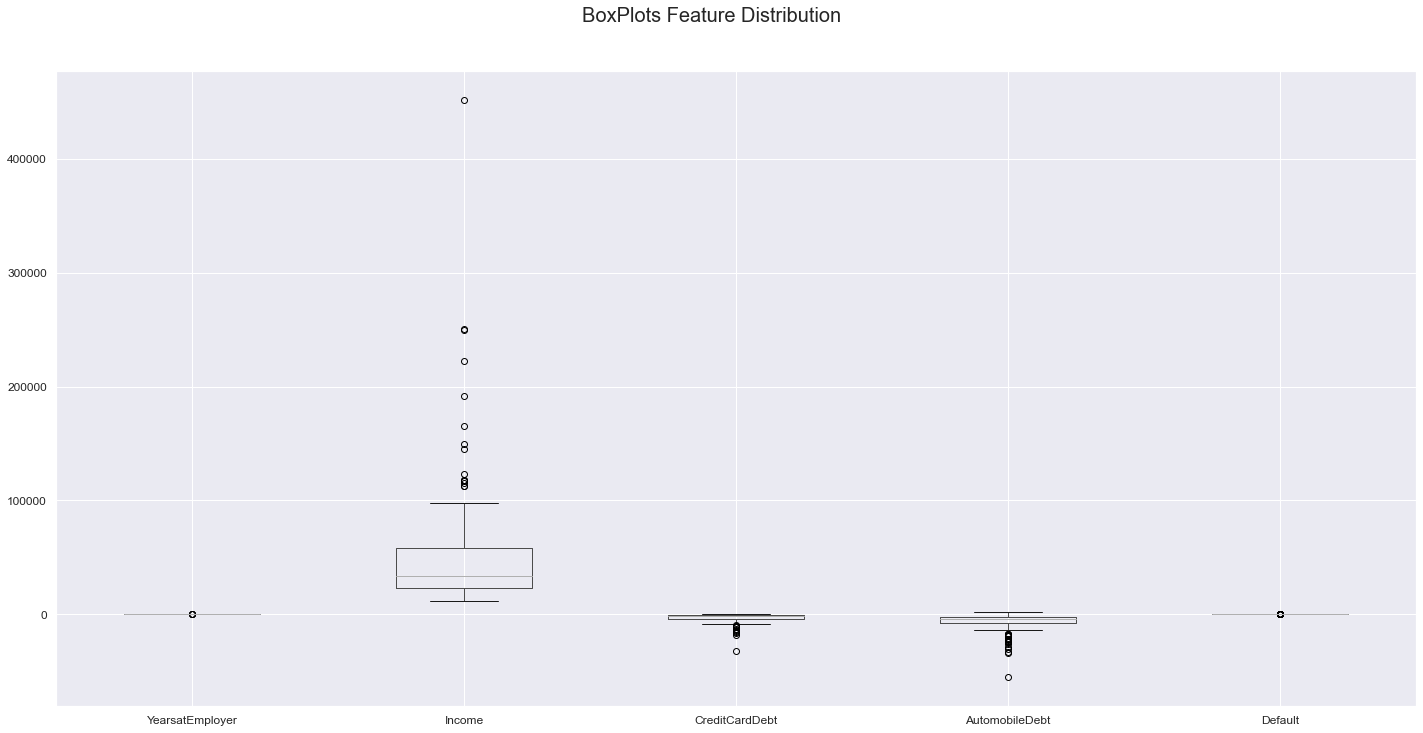

In [9]:
df.boxplot(figsize=(20,10))
plt.suptitle('BoxPlots Feature Distribution', x=0.5, y=1.02, ha='center', fontsize=20)
plt.tight_layout()
plt.show()

### Correlation

In [10]:
df.corr()

,YearsatEmployer,Income,CreditCardDebt,AutomobileDebt,Default
YearsatEmployer,1.00,0.61,-0.44,-0.45,-0.31
Income,0.61,1.00,-0.71,-0.65,-0.05
CreditCardDebt,-0.44,-0.71,1.00,0.60,-0.20
AutomobileDebt,-0.45,-0.65,0.60,1.00,-0.10
Default,-0.31,-0.05,-0.20,-0.10,1.00


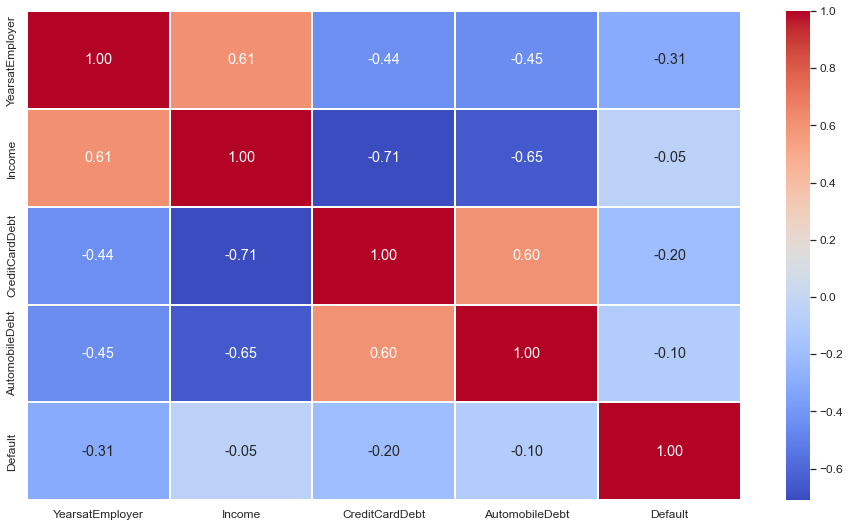

In [11]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.title("", fontsize=20)
plt.show()

## Data Preprocessing

### Treat Missing Values

In [12]:
df.isnull().sum()

YearsatEmployer    0
Income             0
CreditCardDebt     0
AutomobileDebt     0
Default            0
dtype: int64

In [13]:
df.duplicated().sum()

0

## Regression Analysis

## Logistic Regression (StatsModel)

In [14]:
df.columns

Index(['YearsatEmployer', 'Income', 'CreditCardDebt', 'AutomobileDebt', 'Default'], dtype='object')

In [15]:
y = df[['Default']]
X = df[['YearsatEmployer', 'Income', 'CreditCardDebt', 'AutomobileDebt']]

In [16]:
X = sm.add_constant(X)

In [17]:
X.head()

,const,YearsatEmployer,Income,CreditCardDebt,AutomobileDebt
0,1.00,9.39,37843.68,-3246.66,-4794.71
1,1.00,11.97,65765.23,-15597.78,-17632.17
2,1.00,12.46,61002.29,-11401.92,-7910.24
3,1.00,1.39,19952.73,-1233.38,-2408.10
4,1.00,7.49,24970.13,-1135.68,-397.32


In [18]:
logit = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.399594
         Iterations 7


In [19]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:                  200
Model:                          Logit   Df Residuals:                      195
Method:                           MLE   Df Model:                            4
Date:                Wed, 08 Dec 2021   Pseudo R-squ.:                  0.2894
Time:                        12:23:28   Log-Likelihood:                -79.919
converged:                       True   LL-Null:                       -112.47
Covariance Type:            nonrobust   LLR p-value:                 2.456e-13
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.2397      0.314     -0.762      0.446      -0.856       0.377
YearsatEmployer    -0.2769      0.054     -5.119      0.000      -0.383      -0.171
Income          -1.968e-05   7.75e-06     -2.540      0.011   -3.49e-05   -4.49e-06
CreditCardDebt     -0.0004   9.81e-05     -4.317      0.000      -0.001      -0.000
AutomobileDebt  -7.522e-05   4.83e-05     -1.559      0.119      -0.000    1.94e-05
===================================================================================
"""

## Logistic Regression (SKLearn)

### Train Test Split

In [20]:
df.shape

(200, 5)

In [21]:
X = df.iloc[:,:4]
y = df.iloc[:,4]

In [22]:
Counter(y)

Counter({0: 150, 1: 50})

In [23]:
X.values, y.values

(array([[     9.39,  37843.68,  -3246.66,  -4794.71],
        [    11.97,  65765.23, -15597.78, -17632.17],
        [    12.46,  61002.29, -11401.92,  -7910.24],
        [     1.39,  19952.73,  -1233.38,  -2408.1 ],
        [     7.49,  24970.13,  -1135.68,   -397.32],
        [     4.58, 222106.36, -16353.39, -55418.57],
        [    16.9 ,  74282.97,  -4468.47,  -8517.32],
        [    15.93, 117987.39,  -5313.2 ,  -1796.65],
        [    11.96,  55248.19,  -7435.19, -18232.55],
        [     9.47,  33039.88,  -1833.33,  -3631.88],
        [     1.04,  20059.74,  -3898.77,  -2634.01],
        [     4.21,  35386.94,   -191.07,  -1661.07],
        [     7.4 ,  35107.89,  -1315.95,  -1951.39],
        [    22.37, 116698.37,  -8254.79,  -9029.94],
        [    26.63, 165132.22,  -1754.28, -34032.98],
        [     7.84,  41564.57,   -341.03, -11029.77],
        [     7.7 ,  35830.7 ,   -287.23,  -1158.01],
        [     2.75,  17830.42,  -2145.19,  -6227.88],
        [    13.63,  67805.5

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=0, stratify=y)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160, 4), (40, 4), (160,), (40,))

In [26]:
Counter(y_train), Counter(y_test)

(Counter({0: 120, 1: 40}), Counter({0: 30, 1: 10}))

In [27]:
lr = LogisticRegression(random_state=0)

In [28]:
lr.fit(X_train,y_train)

LogisticRegression(random_state=0)

In [29]:
lr.coef_

array([[-0.28517362, -0.00002103, -0.00043335, -0.00007534]])

In [30]:
lr.intercept_

array([-0.01925288])

In [31]:
y_pred = lr.predict(X_test)

In [32]:
y_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1], dtype=int64)

In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       0.70      0.70      0.70        10

    accuracy                           0.85        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.85      0.85      0.85        40



In [34]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[27,  3],
       [ 3,  7]], dtype=int64)

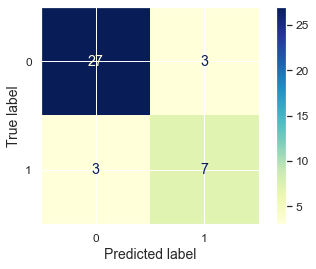

In [35]:
plot_confusion_matrix(estimator=lr, X=X_test, y_true=y_test, cmap='YlGnBu')
plt.show()

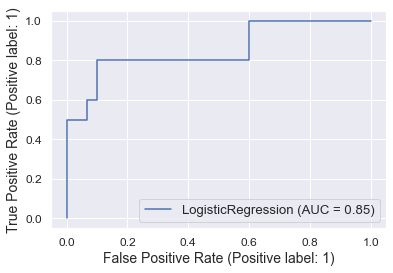

In [36]:
plot_roc_curve(estimator=lr, X=X_test, y=y_test)
plt.show()

In [37]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int64)

In [38]:
y_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1], dtype=int64)

In [39]:
X_test

array([[     3.69,  12517.06,     34.16,   -642.15],
       [     5.46,  41564.97,  -5272.92,  -8861.82],
       [     7.63,  31945.45,  -1571.91,  -2553.28],
       [     7.86,  21613.02,    -26.99,  -1008.01],
       [    13.25,  58643.79,  -5164.71, -11395.31],
       [     7.97,  36913.58,  -1949.95,   -687.46],
       [     4.36,  39647.71,  -1471.09,  -2958.7 ],
       [    15.56,  74097.53,  -7919.7 ,  -8218.17],
       [    14.51,  35721.61,  -2568.89,  -4369.07],
       [     7.61,  24082.79,  -1325.21,   -923.5 ],
       [     6.9 ,  29452.16,   -822.16,  -1067.34],
       [     5.33,  18686.67,   -351.58,  -2285.74],
       [     7.4 ,  35107.89,  -1315.95,  -1951.39],
       [     5.01,  20367.15,   -290.64,  -3493.16],
       [     7.44,  25162.03,   -647.93,  -1691.28],
       [     9.66,  52303.58,  -5215.32, -17393.82],
       [     1.33,  30967.94,  -3426.62,  -4259.57],
       [     4.58, 222106.36, -16353.39, -55418.57],
       [     8.71,  36139.6 ,  -1246.56,  -513

In [40]:
result = {"Actual": y_test, "Predicted": y_pred}

In [41]:
result_df = pd.DataFrame(result)

In [42]:
result_df

,Actual,Predicted
0,0,0
1,0,1
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [43]:
X_test_df = pd.DataFrame(X_test, columns=X.columns)

In [44]:
X_test_df 

,YearsatEmployer,Income,CreditCardDebt,AutomobileDebt
0,3.69,12517.06,34.16,-642.15
1,5.46,41564.97,-5272.92,-8861.82
2,7.63,31945.45,-1571.91,-2553.28
3,7.86,21613.02,-26.99,-1008.01
4,13.25,58643.79,-5164.71,-11395.31
5,7.97,36913.58,-1949.95,-687.46
6,4.36,39647.71,-1471.09,-2958.70
7,15.56,74097.53,-7919.70,-8218.17
8,14.51,35721.61,-2568.89,-4369.07
9,7.61,24082.79,-1325.21,-923.50


In [45]:
table = pd.concat([X_test_df,result_df],axis=1)

In [46]:
table

,YearsatEmployer,Income,CreditCardDebt,AutomobileDebt,Actual,Predicted
0,3.69,12517.06,34.16,-642.15,0,0
1,5.46,41564.97,-5272.92,-8861.82,0,1
2,7.63,31945.45,-1571.91,-2553.28,0,0
3,7.86,21613.02,-26.99,-1008.01,0,0
4,13.25,58643.79,-5164.71,-11395.31,0,0
5,7.97,36913.58,-1949.95,-687.46,0,0
6,4.36,39647.71,-1471.09,-2958.70,0,0
7,15.56,74097.53,-7919.70,-8218.17,0,0
8,14.51,35721.61,-2568.89,-4369.07,0,0
9,7.61,24082.79,-1325.21,-923.50,0,0


In [47]:
table.columns

Index(['YearsatEmployer', 'Income', 'CreditCardDebt', 'AutomobileDebt', 'Actual', 'Predicted'], dtype='object')

In [48]:
Counter(table.Actual)

Counter({0: 30, 1: 10})

In [49]:
Counter(table.Predicted)

Counter({0: 30, 1: 10})

In [50]:
table.sum()

YearsatEmployer       329.95
Income            1962915.76
CreditCardDebt    -139524.21
AutomobileDebt    -295774.15
Actual                 10.00
Predicted              10.00
dtype: float64

In [51]:
debt = table.CreditCardDebt.sum() + table.AutomobileDebt.sum()
debt / 200

-2176.4918

In [52]:
(table.Income.sum() - debt) / 200

11991.0706

## Model Evaluation

In [53]:
test = pd.read_csv("test2.csv")

In [54]:
test

,YearsatEmployer,Income,CreditCardDebt,AutomobileDebt
0,0.35,12180.60,-2057.28,-3696.31
1,4.47,38536.24,-6970.27,-3018.06
2,9.30,30601.95,-2891.77,-1673.64
3,8.43,15587.51,-38.11,-1757.87
4,5.40,27598.76,-775.59,-4374.05
...,...,...,...,...
195,16.02,70526.44,-3099.77,-13605.37
196,2.97,17317.67,-122.44,104.16
197,3.97,29402.89,-441.77,-3908.37
198,13.97,43729.53,-243.76,-2534.89


In [55]:
test_pred = lr.predict(test)
test_pred

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [56]:
test_pred_df = pd.DataFrame(test_pred, columns=["Prediction"])
test_pred_df

,Prediction
0,1
1,1
2,0
3,0
4,0
...,...
195,0
196,0
197,0
198,0


In [57]:
actual_test = pd.read_csv("test.csv")
actual_test

,UniqueApplicantID,Age,YearsatEmployer,YearsatAddress,Income,CreditCardDebt,AutomobileDebt,Default
0,201,25.92,0.35,0.24,12180.60,-2057.28,-3696.31,1
1,202,27.80,4.47,0.37,38536.24,-6970.27,-3018.06,1
2,203,37.33,9.30,0.02,30601.95,-2891.77,-1673.64,0
3,204,28.00,8.43,1.06,15587.51,-38.11,-1757.87,0
4,205,39.24,5.40,0.74,27598.76,-775.59,-4374.05,0
...,...,...,...,...,...,...,...,...
195,396,49.66,16.02,0.24,70526.44,-3099.77,-13605.37,0
196,397,23.78,2.97,0.70,17317.67,-122.44,104.16,0
197,398,32.84,3.97,0.75,29402.89,-441.77,-3908.37,0
198,399,43.89,13.97,0.08,43729.53,-243.76,-2534.89,0


In [58]:
table2 = pd.concat([actual_test,test_pred_df], axis=1)
table2

,UniqueApplicantID,Age,YearsatEmployer,YearsatAddress,Income,CreditCardDebt,AutomobileDebt,Default,Prediction
0,201,25.92,0.35,0.24,12180.60,-2057.28,-3696.31,1,1
1,202,27.80,4.47,0.37,38536.24,-6970.27,-3018.06,1,1
2,203,37.33,9.30,0.02,30601.95,-2891.77,-1673.64,0,0
3,204,28.00,8.43,1.06,15587.51,-38.11,-1757.87,0,0
4,205,39.24,5.40,0.74,27598.76,-775.59,-4374.05,0,0
...,...,...,...,...,...,...,...,...,...
195,396,49.66,16.02,0.24,70526.44,-3099.77,-13605.37,0,0
196,397,23.78,2.97,0.70,17317.67,-122.44,104.16,0,0
197,398,32.84,3.97,0.75,29402.89,-441.77,-3908.37,0,0
198,399,43.89,13.97,0.08,43729.53,-243.76,-2534.89,0,0


In [59]:
Counter(table2.Default)

Counter({1: 50, 0: 150})

In [60]:
Counter(table2.Prediction)

Counter({1: 37, 0: 163})

In [61]:
no_default = table2[table2["Prediction"] == 0]

In [62]:
debt = no_default.CreditCardDebt.sum() + no_default.AutomobileDebt.sum()
debt / 163

-7300.799018404908

#### Python code done by Dennis Lam